In [4]:
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
import xir
import vart
import vitis_ai_library
import os

from torchvision import transforms as T
from torchvision.transforms import functional as F

In [22]:
dataset_path = "./images_folder/"
model_name = "./build_test/comp_model/UNet2D_compiled.xmodel"
image_name = "00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png"
DEBUG = False

In [23]:
image_folder_path = os.path.join(dataset_path, 'images')
mask_folder_path = os.path.join(dataset_path, 'masks')

In [24]:
def correct_dims(*images):
    corr_images = []
    for img in images:
        if len(img.shape) == 2:
            corr_images.append(np.expand_dims(img, axis=2))
        else:
            corr_images.append(img)
    if len(corr_images) == 1:
        return corr_images[0]
    else:
        return corr_images

In [25]:
def preprocess_fn(image_path):
    '''
    Image pre-processing.
    Opens image as grayscale then normalizes to range 0:1
    input arg: path of image file
    return: numpy array
    '''
    image = io.imread(os.path.join(image_folder_path, image_name))
    mask = io.imread(os.path.join(mask_folder_path, image_name))
    image, mask = correct_dims(image, mask)
    image, mask = F.to_pil_image(image), F.to_pil_image(mask)
    #random crop
    i, j, h, w = T.RandomCrop.get_params(image, (256, 256))
    image, mask = F.crop(image, i, j, h, w), F.crop(mask, i, j, h, w)
    
    data = np.asarray(image, dtype=np.float32) / 255 #maybe only divide by 128 as the scaling is in signed integer, probably it is also necessary to substract by 1 after that
    return data, mask

In [26]:
def run_inference(image_name):
    input_image, mask = preprocess_fn(image_name)
    
    g = xir.Graph.deserialize(model_name)
    
    
    if DEBUG:
        print("Now printing subgraphs: \n")
        subgraphs = g.get_root_subgraph().toposort_child_subgraph()
        subgraph_number = 0
        for graph in subgraphs:
            print("subgraph " + str(subgraph_number) + " " +  graph.get_name())
            subgraph_number += 1
        print("\n ____________________________________________________\n allsubgraphs printed")
        
        
    runner = vitis_ai_library.GraphRunner.create_graph_runner(g)
    # get a list of runner inputs
    inputTensors = runner.get_input_tensors()
    output_tensor_buffers = runner.get_outputs() 
    
    if DEBUG:
        print("Now printing input tensors: \n")
        for inputTensor in inputTensors:
            print('Input tensor :',inputTensor.name, inputTensor.dims)
        print("\n ____________________________________________________\n input tensors printed")
    
    
    if DEBUG:
        print("\n Shape of image: " + str(input_image.shape) + "\n")
    
    inputData = []
    for inputTensor in inputTensors:
        inputData.append(input_image.reshape(inputTensor.dims))
    job_id = runner.execute_async(inputData, output_tensor_buffers)
    runner.wait(job_id)
    
    return np.array(output_tensor_buffers[0], np.int8), mask

In [27]:
output, ground_truth_mask = run_inference(image_name)

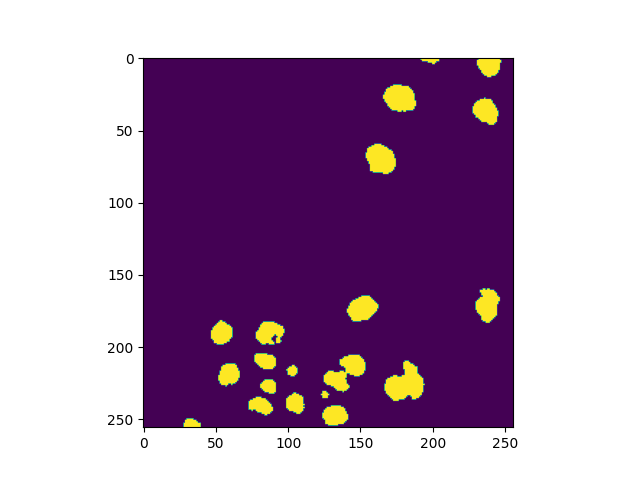

In [28]:
#plot second channel from output
%matplotlib widget
#mask[mask > 0.1] = 1
mask_fig = plt.figure()
plt.imshow(output[0,:,:,1])

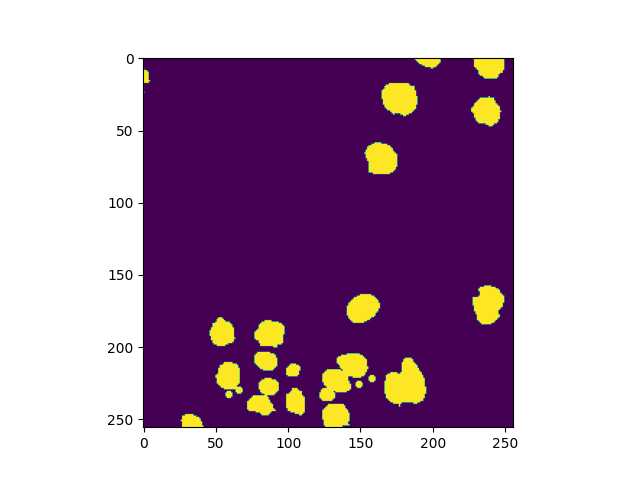

In [29]:
#plot reference mask
%matplotlib widget
mask_ref_fig = plt.figure()
plt.imshow(ground_truth_mask)

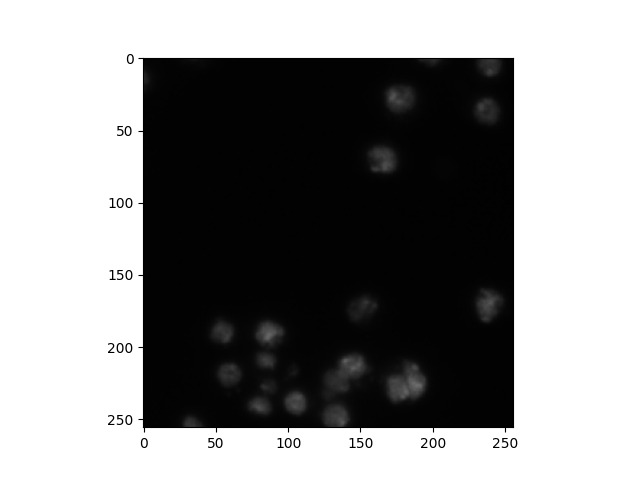

In [30]:
#plot original image
%matplotlib widget
image = plt.figure()
plt.imshow(io.imread(os.path.join(image_folder_path, image_name)))